In [1]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import math
from scipy import stats
import random
from pyper import *
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, r
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
from scipy import stats
from neurocombat_sklearn import CombatModel
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

/opt/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/opt/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


# 1. Generate Simulated Dataset

## 1.1 Generate dummy dataset
The function ***generate_dummy_dataset*** is used to generate handcrafted trivial dataset. It takes five paramaters:
1. **label_list**: a list of distinct labels, e.g. if there are three distinct classes then [1,2,3]
2. **n_samples_label**: a list of how many samples are there for each of the distinct classes. e.g. [20,10,5], 20 samples for class 1; 10 samples for class 2; 5 samples for class 3 etc.
3. **inform_mean_list**: a 2-d array of the mean values for each feature of each class. e.g. [[2,3,4,5],[6,7,8,9],[10,11,12,13]]. It indicates that there are four features in total. [2,3,4,5] is the mean value for each feature of class 1 around which the datapoint will be generated.
3. **inform_std_list**: a 1-d array of the standard deviation values for each feature column when generating the data points. e.g. [0.1, 0.2, 0.1, 0.1]. It indicates that the std value for generating feature 1 is 0.1 and etc.
4. **n_noise**: optional parameter, default value is None. When specified as a list: [number_of_noise_columns,(noise_range_lower, noise_range_higher)]. E.g. [1, (0, 100)] means that one column of noise data will be generated, it is generated within the range from 0 to 100.

In [2]:
def generate_dummy_dataset(label_list, n_samples_label, inform_mean_list, inform_std_list, n_noise=None):
    # check if the input parameters are correct
    n_features = len(inform_std_list)
    n_samples = sum(n_samples_labels)
    for i in range(len(inform_mean_list)):
        assert len(inform_mean_list[i]) == n_features
    
    assert len(label_list) == len(n_samples_labels)
    
    X,y = [],[]
    for i,v in enumerate(n_samples_labels):
        class_data = []
        for j in range(n_features):
            col = np.random.normal(inform_mean_list[i][j], inform_std_list[j], v).reshape(-1,1)
            class_data.append(col)
        class_labels = [label_list[i] for k in range(v)]
        class_data = np.concatenate(class_data, axis=1).reshape(v,n_features)
        X.append(class_data)
        y.append(class_labels)
        
    X = np.concatenate(X,axis=0)
    y = np.asarray([item for sublist in y for item in sublist])
    
    if n_noise is not None:
        n_noise_col = n_noise[0]
        noise_range = n_noise[1]
        noise_data = np.random.uniform(low=noise_range[0], high=noise_range[1], size=(n_samples,n_noise_col))
        X = np.concatenate((X, noise_data), axis=1)
        
    return X, y

The function ***swap*** is a helper function to shuffle a particular column of features among different classes. It takes three parameters:
1. X_base: this is the base data to be swapped
2. class_1_swap: this is the feature index from class_1
3. class_2_swap: this is the feature index from class_2
4. feature_index: this is the column index on which swap is performed

In [3]:
def swap(X_base, class_1_swap, class_2_swap, feature_index):
    X_temp = X_base.copy()
    for i in range(len(class_1_swap)):
        temp = X_temp[class_1_swap[i]][feature_index]
        X_temp[class_1_swap[i]][feature_index] = X_temp[class_2_swap[i]][feature_index]
        X_temp[class_2_swap[i]][feature_index] = temp
    return X_temp

def swap_multiple(X_base,feature_index,class_1_swap,class_2_swap,class_3_swap):
    X_temp = np.copy(X_base)
    for i in range(len(class_1_swap)):
        if i<3:
            temp_1 = X_temp[class_1_swap[i]][feature_index]
            X_temp[class_1_swap[i]][feature_index] = X_temp[class_3_swap[i]][feature_index]
            X_temp[class_3_swap[i]][feature_index] = temp_1
        
            temp_2 = X_temp[class_2_swap[i]][feature_index]
            X_temp[class_2_swap[i]][feature_index] = X_temp[class_3_swap[i]][feature_index]
            X_temp[class_3_swap[i]][feature_index] = temp_2
            
        elif i>=3 and i<6:
            temp_3 = X_temp[class_1_swap[i]][feature_index]
            X_temp[class_3_swap[i]][feature_index] = X_temp[class_1_swap[i]][feature_index]
            X_temp[class_1_swap[i]][feature_index] = temp_1
        
            temp_2 = X_temp[class_2_swap[i]][feature_index]
            X_temp[class_2_swap[i]][feature_index] = X_temp[class_3_swap[i]][feature_index]
            X_temp[class_3_swap[i]][feature_index] = temp_2
            
        elif i>=6 and i<9:
            temp_1 = X_temp[class_1_swap[i]][feature_index]
            X_temp[class_2_swap[i]][feature_index] = X_temp[class_1_swap[i]][feature_index]
            X_temp[class_1_swap[i]][feature_index] = temp_1
        
            temp_2 = X_temp[class_3_swap[i]][feature_index]
            X_temp[class_3_swap[i]][feature_index] = X_temp[class_1_swap[i]][feature_index]
            X_temp[class_1_swap[i]][feature_index] = temp_2
        else:
            temp_1 = X_temp[class_1_swap[i]][feature_index]
            X_temp[class_2_swap[i]][feature_index] = X_temp[class_1_swap[i]][feature_index]
            X_temp[class_1_swap[i]][feature_index] = temp_1
        
            temp_2 = X_temp[class_3_swap[i]][feature_index]
            X_temp[class_3_swap[i]][feature_index] = X_temp[class_1_swap[i]][feature_index]
            X_temp[class_1_swap[i]][feature_index] = temp_2
    return X_temp

In [4]:
def add_redundant(X,index,slope,intercept):
    X_temp = X.copy()
    redundant_col = X_temp[:,index] * slope + intercept
    X_with_redundant = np.concatenate((X_temp, redundant_col.reshape(-1,1)),axis=1)
    return X_with_redundant

def add_noise(X, low, high, size):
    X_temp = X.copy()
    noise_data = np.random.uniform(low=low, high=high, size=(X_temp.shape[0],size))
    X_with_noise = np.concatenate((X_temp, noise_data), axis=1)
    return X_with_noise

def generate_redundant(X,index,slope,intercept):
    X_temp = X.copy()
    redundant_col = X_temp[:,index] * slope + intercept
#     X_with_redundant = np.concatenate((X_temp, redundant_col.reshape(-1,1)),axis=1)
    return redundant_col

def generate_noise(X, low, high, size):
    X_temp = X.copy()
    noise_data = np.random.uniform(low=low, high=high, size=(X_temp.shape[0],size))
#     X_with_noise = np.concatenate((X_temp, noise_data), axis=1)
    return noise_data

# 1.1.1 Example

This demonstrate the data generated by the above mentioned function. The following parameters are specified:
1. label_list = [1,2]
2. n_samples_labels = [20,20]
3. inform_mean_list = [[2,5,7,9],[9,1,2,6]]
4. inform_std_list = [0.001, 0.001, 0.001, 0.001]
5. n_noise = [1,(-100,100)]

In [5]:
label_list = [1,2]
n_samples_labels = [20,20]
inform_mean_list = [[2,5,7,9],[9,1,2,6]]
inform_std_list = [0.001, 0.001, 0.001, 0.001]
n_noise = [1,(-100,100)]

X_example, y_example = generate_dummy_dataset(label_list, n_samples_labels, inform_mean_list,inform_std_list, n_noise)
print("X_example: \n", X_example)
print("y_example: \n", y_example)

class_1_index = [2, 4, 6, 8, 10]
class_2_index = [21, 23, 25, 27, 29]

X_swapped = swap(X_example, class_1_index, class_2_index, 0)
print("X_swapped: \n", X_swapped)

X_example: 
 [[  2.00150688   5.00152735   7.0010124    9.00043277 -77.23786976]
 [  1.99996713   4.99994481   7.00100481   8.9987445  -58.19211451]
 [  2.00061563   4.99928162   7.00016259   8.99851129  -5.83532171]
 [  2.00169405   4.99997798   7.00072324   9.00159728  50.99379802]
 [  2.00192005   4.99985331   7.00118071   9.00031567  -4.97754759]
 [  2.00049526   5.00077802   6.99931205   9.00254345  -5.92638748]
 [  2.00027246   4.99951547   6.99983523   8.9993191  -78.99706462]
 [  1.9993382    4.99996725   6.99832444   9.00097234   4.24044887]
 [  1.99977861   4.99908674   6.99994979   9.00009032  14.154597  ]
 [  2.00025964   4.99997629   7.00173263   9.00133157  51.37355882]
 [  2.00058192   4.99801743   7.00133427   9.00046306 -59.06186125]
 [  1.99986563   4.99972895   7.0011038    8.9990945   34.75946369]
 [  1.99941749   4.99893599   6.99980724   9.00034373 -53.46981772]
 [  2.00143446   5.00049247   7.00091765   9.00005265 -30.74678706]
 [  1.99890261   4.99928235   6.999

# 2. Helper Functions for Data Visualization

## 2.1 Compute the Mutual Information Matrix of the features

In [6]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def featureTargetRelevance(X, y, n_informative):
    feature_scores = mutual_info_regression(X, y, random_state=0)
    fig,ax = plt.figure(figsize = (10, 5)) 
    sort_value = sorted(feature_scores, reverse=True)
    sort_index = np.argsort(-1*feature_scores)
    column = np.asarray([i for i in range(0,n_total)])
    # plt.bar(column, sort_value, color ='maroon')
    # creating the bar plot 
    for i,v in enumerate(sort_index):
        if i < n_informative:
            plt.bar(column[i], sort_value[i], color ='maroon')
        else:
            plt.bar(column[i], sort_value[i], color ='blue')
    plt.xticks(column, sort_index)
    plt.xlabel("Feature Index") 
    plt.ylabel("Mutual Information Score with target") 
    plt.title("Mutual Information Score") 
    plt.show() 
    
def computeMIMatrix(X_mrmr, index):
    n_features = X_mrmr.shape[1]
    array = np.zeros(n_features * n_features)
    array = array.reshape(n_features, n_features)
    labels = []
    for i in range(n_features):
        tmp = []
        for j in range(n_features):
            # print("i: {}; j:{}".format(i,j))
            mutual_info = mutual_info_regression(X_mrmr[:,i].reshape(-1,1), X_mrmr[:,j])
            array[i][j] = mutual_info
            tmp.append("({},{}) \n {}".format(i,j, round(mutual_info[0], 7)))
            # print(mutual_info)
        labels.append(tmp)
    fig,ax = plt.subplots(figsize=(15,10))
    title = "Mutual Information between pairwise features"
    sns.heatmap(array, annot=labels,fmt="",cmap="Blues", linewidth=0.3, ax=ax)
    plt.show()
    plt.savefig('computed_mim_' + str(index) + '.png')
    return array, labels

def visualize_clusters(X,y,index):
    pca = PCA(n_components=2).fit(X)
    pca_2d = pca.transform(X)
    fig,ax = plt.subplots(figsize=(10,5))
    plt.scatter(pca_2d[:,0],pca_2d[:,1], c=y, alpha=0.5)
    plt.title("ground truth")
    plt.xlabel('x')
    plt.ylabel('y')
#     plt.savefig('class_sep_' + str(index) + '.png')

# 3. Test Feature Reduction Step
## 3.1 Feature Reduction Step Implementation

In [7]:
def t_test(X, y):
    
    def separate(X, y):
        # Y is the classes (1=stable, 2=progressor)
        P_X, S_X = [], []
        for i in range(X.shape[0]):
            if  y[i] == 0:
                S_X.append(X[i])
            elif y[i] == 1:
                P_X.append(X[i])
        return np.asarray(P_X), np.asarray(S_X)

    def t_test(P, S, y):
        t_vals = []
        for i in range(P.shape[1]):
            t_score, p_val = stats.ttest_ind(P[:,i], S[:,i])
            tuple_ = (abs(t_score), abs(p_val))
            t_vals.append((tuple_, i))
        return t_vals

    def select(X, y, t_vals, percentage=.5):
        total_nfeatures = X.shape[1]
        filtered_nfeatures = math.ceil(total_nfeatures*percentage)
        print("total_nfeatures: ",total_nfeatures)
        print("filtered_nfeatures", filtered_nfeatures)
        sorted_t_val = sorted(t_vals, key=lambda tup: tup[0][0], reverse=True)
        print(sorted_t_val)
        selected_indices = [i[1] for i in sorted_t_val[:filtered_nfeatures]]
        sorted_selected_indices = sorted(selected_indices)
        X_reduced = X[:,sorted_selected_indices]
        return X_reduced, sorted_selected_indices
    
    P_X, S_X = separate(X, y)
    t_vals = t_test(P_X, S_X, y)
    X_reduced, selected_indices = select(X, y, t_vals)
    return X_reduced, selected_indices

## 3.2 Feature Reduction Step Validation

In [8]:
# create a simulated dataset
label_list = [0,1]
n_samples_labels = [150,150]
inform_mean_list = [[2,9,7,2],[9,1,2,6]]
inform_std_list = [0.0001, 0.0001, 0.0001, 0.0001]
n_noise = [3,(0,100)]

X_ttest_base, y_ttest_base = generate_dummy_dataset(label_list, n_samples_labels, inform_mean_list,inform_std_list, n_noise)
print("X_ttest_base: \n", X_ttest_base)
print("y_ttest_base: \n", y_ttest_base)

X_after_test, columns_ttest = t_test(X_ttest_base, y_ttest_base)
print("columns_ttest: ", columns_ttest)

X_ttest_base: 
 [[ 2.00008781  8.99991014  6.99992704 ... 33.89093117 34.41684255
  64.95773601]
 [ 1.99996577  9.00004918  6.99988772 ... 65.91249977 19.07640827
  58.29703488]
 [ 2.00001445  9.0000412   6.9999502  ... 33.96978063 32.88178781
  52.44218921]
 ...
 [ 8.99984588  1.00020535  2.00005979 ...  4.52918875 21.78474602
  48.29439547]
 [ 8.99986572  1.00004485  1.99986945 ... 55.33607814 35.79937252
  55.10201973]
 [ 8.99982942  0.99996856  1.9999689  ... 47.65489788 22.72236447
  97.86076689]]
y_ttest_base: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1

# 3. Test Subtype Clustering Step
## 3.1 Subtype Clustering Step Implementation

In [9]:
from snf import compute

class Clustering():

    def __init__(self, debug_mode=False):
        """Apply fit_transform on the training data

            Arguments
            ---------
                debug_mode: boolean
                    If true, intermediate results will be printed for debugging purposes 
                    at the end of each function call.
        """
        self.debug_mode = debug_mode
        pass

    # setter for number of subclusters for P
    def setNumP(self, numP):
        self.numP = numP

    # setter for number of subclusters for S
    def setNumS(self, numS):
        self.numS = numS

    # Step1. Separate out P and S
    def separate(self, X, y):
        """Separate out the progressor and stable instances to be used for clustering later. 

            As the data in is reindexed by the stratifiedKfold. It is important for us
            to save the indexes of the rows before we separate them out and do clustering 
            accordingly. In this function, while the data is splitted into separate lists 
            by class, the original index for each row is saved. After the clustering is done, 
            we will reindex our combined data set according to the saved indexes.

            Arguments
            ---------
                X: numpy.ndarray
                    The combined data
                y: numpy.ndarray
                    The combined data labels.
            Returns
            -------
                P_X: list
                    Progressor data
                P_y: list
                    Progressor data labels
                S_X: list
                    Stable data
                S_y: list
                    Stable data labels     
        """

        # initialize empty lists to store index of P&S instances in the
        # original data
        index_P, index_S = [], []

        # initialize lists to store the separated P and S instances
        P_X, P_y, S_X, S_y = [], [], [], []
        # store P and S instances separately and keep track of the indexes in
        # the original data

        for i in range(0, y.shape[0]):
            if y[i] == 1:
                S_X.append(X[i])
                S_y.append(y[i])
                index_S.append(i)
            else:
                P_X.append(X[i])
                P_y.append(y[i])
                index_P.append(i)

        # store the indexes as a global attribute for the clasds
        self.index_P = index_P
        self.index_S = index_S

        # print all the computed matrxi if debug mode is enabled
        if self.debug_mode == True:
            print("index_P", self.index_P)
            print("index_S", self.index_S)

#         print("P_X separate", P_X)
        return np.asarray(P_X), np.asarray(P_y), np.asarray(S_X), np.asarray(S_y)

    def clusteringP(self, P_X):
        """Apply Spectral Clustering on Progressor data.

            SpectralClustering is performed on P class instances. The number of clusters 
            is specified by the global attribute num_P. At the end of the step, the original
            labels will be discarded and the new labels will be attached to the end of the data
            for convenience. The assign_labels for the SpectralClustering is "discrete" and 
            random_state is set to 0. 

            Arguments
            ---------
                P_X: list
                    The progressor data.
            Returns
            -------
                P_X_clustered: numpy.ndarray
                    The combined clustered progressor data with new labels attached to the end.
        """
        affinity_networks = compute.make_affinity(P_X, metric='euclidean', K=self.numP, mu=0.5)
        
        clusteringP = SpectralClustering(affinity='precomputed',
            n_clusters=self.numP, random_state=0).fit(affinity_networks)
        
        labels = clusteringP.labels_.reshape(-1, 1)
        P_X = np.asarray(P_X)
        P_X_clustered = np.concatenate((P_X, labels), axis=1)

        if self.debug_mode == True:
            print("P labels", np.reshape(labels, (1, -1)))
            print("P_X_clustered", P_X_clustered)

        return P_X_clustered

    def clusteringS(self, S_X):
        """Apply Spectral Clustering on Stable data.

            SpectralClustering is performed on the S class instances. The number of clusters 
            is specified by the global attribute num_S. At the end of the step, the original
            labels will be discarded and the new labels will be attached to the end of the data
            for convenience. The assign_labels for the SpectralClustering is "discrete" and 
            random_state is set to 0. 

            Arguments
            ---------
                S_X: list
                    The progressor data.
            Returns
            -------
                S_X_clustered: numpy.ndarray
                    The combined clustered progressor data with new labels attached to the end.
        """

        affinity_networks = compute.make_affinity(S_X, metric='euclidean', K=self.numS, mu=0.5)
        
        clusteringS = SpectralClustering(affinity='precomputed',
            n_clusters=self.numS, random_state=0).fit(affinity_networks)

        labels = clusteringS.labels_
        labels = labels + self.numP
        S_X = np.asarray(S_X)
        labels = labels.reshape(-1, 1)
        S_X_clustered = np.concatenate((S_X, labels), axis=1)

        if self.debug_mode == True:
            print("S labels", np.reshape(labels, (1, -1)))
            print("S_X_clustered", S_X_clustered)

        return S_X_clustered

    def transform(self, X, y):
        """Apply Spectral Clustering on stable data and progressor data. 
            Step 1. Separate data out into P and S classes. Save the original data index as 
            the data rows will be reindexed for clustering. 
            Step 2. Perform clustering for P class based on num_P. Attach the new labels.
            Step 3. Perform clustering for S class based on num_S. Attach the new labels. 
            Step 4. Combine the newly clustered P class data and S class data. Reindex the 
            data rows according to the saved indexes. 
            Arguments
            ---------
                X: numpy.ndarray
                    The combined data of both P and S instances.
                y: numpy.ndarray
                    The combined data labels.
            Returns
            -------
                X_output: numpy.ndarray
                    The combined data with newly clustered labels attached.
        """

        P_X, P_y, S_X, S_y = self.separate(X, y)

        P_X_clustered = self.clusteringP(P_X)
        S_X_clustered = self.clusteringS(S_X)

        P_X_clustered_with_index = np.concatenate(
            (P_X_clustered, (np.array(self.index_P)).reshape(-1, 1)), axis=1)
        S_X_clustered_with_index = np.concatenate(
            (S_X_clustered, (np.array(self.index_S)).reshape(-1, 1)), axis=1)

        X_combined_with_index = np.concatenate(
            (P_X_clustered_with_index, S_X_clustered_with_index), axis=0)

        X_sorted = X_combined_with_index[
            np.argsort(X_combined_with_index[:, -1])]
        new_labels = X_sorted[:,-2]
        X_output = X_sorted[:, :-2]

        if self.debug_mode == True:
            print("P_X_clustered_with_index", P_X_clustered_with_index)
            print("S_X_clustered_with_index", S_X_clustered_with_index)
            print("X_sorted", X_sorted)
            print("X_output", X_output)
            print("X_output.labels", X_output[:, -1])

        return X_output, new_labels

## 3.2 Subtype Clustering Step Validation

In [10]:
# Generate the base dataset
label_list = [0,1,2]
n_samples_labels = [100,100,100]
inform_mean_list = [[2,9,7,2],[9,1,2,6],[5,9,1,4]]
inform_std_list = [0.0001, 0.0001, 0.0001, 0.0001]
n_noise = [1,(0,100)]

n_clusters = len(n_samples_labels)

X_clustering, y_clustering = generate_dummy_dataset(label_list, n_samples_labels, inform_mean_list,inform_std_list, n_noise)
print("X_ttest_base: \n", X_clustering)
print("y_ttest_base: \n", y_clustering)

X_ttest_base: 
 [[ 2.00003301  8.99998184  6.99983161  2.0000976  41.95859606]
 [ 2.00014549  8.99988515  6.99989408  1.999937   18.40077698]
 [ 2.00012736  9.00002724  7.0000034   2.00002187 25.61476857]
 ...
 [ 4.99997194  9.0000797   1.00008047  4.00003827 30.28216331]
 [ 5.00008366  9.00009076  0.99994711  3.99990874 39.72184297]
 [ 5.00010281  9.00018023  1.00018202  4.00002559 92.19320261]]
y_ttest_base: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

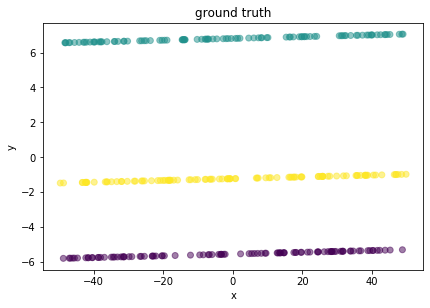

Ground Truth Label: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]


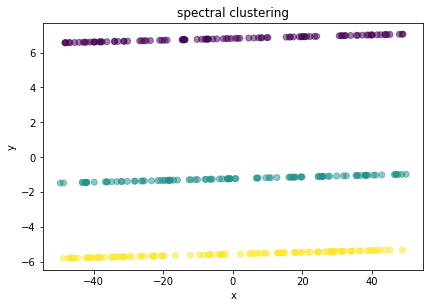

Labels returned by Subtype Clustering Step: 
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2).fit(X_clustering)
pca_2d = pca.transform(X_clustering)

################################ ground truth with PCA ################################
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.scatter(pca_2d[:,0],pca_2d[:,1], c=y_clustering, alpha=0.5)
plt.title("ground truth")
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print("Ground Truth Label: \n", y_clustering)

################################ spectral clustering ################################
clustering = Clustering()
clustering.setNumP(n_clusters)
clustered = clustering.clusteringP(X_clustering)
clustered_label = clustered[:,-1]

plt.figure(figsize=(15,10))
plt.subplot(222)
plt.title("spectral clustering")
plt.scatter(pca_2d[:,0],pca_2d[:,1], c=clustered_label, alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print("Labels returned by Subtype Clustering Step: \n", clustered_label)

# 4. Feature Selection Step (MRMR)
## 4.1 Feature Selection Step Implementation

In [12]:
def mrmrSelection(dataframe, nFeature):
    """Perform MRMR on the passed in data. 

        This function performs feature selection based on the mRMRe feature selection. 
        It utilizes the mRMRe package originally written in R. A python wrapper for R is
        used here. The eMRMRe returns a list of the selected column indices given the 
        number of features to be selected. 

        Arguments
        ---------
            dataframe: pandas.DataFrame
                The dataframe containing clustered data. 
        Returns
        -------
            df_: pandas.DataFrame
                The dataframe with only selected columns.
            labels: pandas.DataFrame
                The dataframe of only the labels
            colum_indices: list
                The list of indices of the selected columns
    """ 
    base = importr('base')
    mr = importr('mRMRe')
    pandas2ri.activate()
    # Convert the data into R format
    with localconverter(ro.default_converter + pandas2ri.converter):
        rdataframe = ro.conversion.py2rpy(dataframe)
    mrmrData = mr.mRMR_data(data = (rdataframe))
    solutionCount = 1
    selectionEnsemble = mr.mRMR_ensemble("mRMRe.Data",data = mrmrData, target_indices = (dataframe.shape[1]),
          feature_count = nFeature, solution_count = solutionCount)
    colum_indices =(mr.solutions(selectionEnsemble)[0]-1)
    mutual_information_matrix = mr.mim(mrmrData)
    df_ = pd.DataFrame()
    for i,v in enumerate(colum_indices):
        df_[i] = dataframe[v[0]]
    labels = dataframe.iloc[:,-1]
    colum_indices = list(np.reshape(colum_indices,(1,-1))[0])
    return df_, labels, colum_indices, mutual_information_matrix

## 4.2 Feature Selection Step Validation
### 4.2.1 Generate Base Dataset

In [18]:
# Generate the base dataset
label_list = [0,1,2]
n_samples_labels = [40,40,40]
inform_mean_list = [[1,2,3,4,5],[5,4,3,2,1],[9,5,2,4,3]]
inform_std_list = [0.0001, 0.0001, 0.0001, 0.0001, 0.0001]

n_clusters = len(n_samples_labels)

X_mrmr_base, y_mrmr_base = generate_dummy_dataset(label_list, n_samples_labels, inform_mean_list,inform_std_list)
print("X_mrmr_base: \n", X_mrmr_base)
print("y_mrmr_base: \n", y_mrmr_base)

reduandant_col_1 = generate_redundant(X_mrmr_base,1, 2.5, 0.4)
print("reduandant_col_1: \n", reduandant_col_1)

reduandant_col_2 = generate_redundant(X_mrmr_base,2, 1.1, 0.8)
print("reduandant_col_2: \n", reduandant_col_2)

noise_col_1 = generate_noise(X_mrmr_base, 1, 1000, 2)
print("noise_col_1: \n", noise_col_1)

X_mrmr_base: 
 [[1.00010652 2.00008438 3.00015007 3.99988273 5.00005111]
 [0.99989987 2.00013792 3.00018704 3.99995085 5.00004099]
 [0.99987929 2.00008607 2.9999125  4.00002144 5.00000252]
 [0.99987902 1.99993722 2.99994848 4.0000439  5.00001021]
 [0.99984214 1.99991652 3.00000059 3.99991542 5.00011455]
 [1.00007084 2.00009476 2.99993323 4.00000431 5.00015853]
 [0.99990007 2.00004678 3.00014194 4.00005897 5.00021265]
 [0.99992121 1.99994896 2.99985423 4.00009722 4.99993161]
 [0.99986987 1.99995069 2.99999669 4.00003586 4.99994387]
 [1.00000798 2.00002226 2.9997394  3.99998948 5.0001219 ]
 [0.99974706 1.99989672 3.00001814 4.00004066 5.00008066]
 [0.99992453 1.99979054 2.99991346 4.00006148 5.00000795]
 [0.99987262 2.00012455 2.99988753 3.99997944 5.0000419 ]
 [1.00007779 1.99988109 2.99981927 3.99994856 4.9999962 ]
 [0.99998553 2.00007735 3.00005237 3.99994001 5.00006452]
 [1.00006352 1.99996486 3.00008585 4.00005793 5.00010791]
 [1.00003854 2.00004321 2.99993418 4.0001174  5.00022706]

### 4.2.2 Base Dataset + Swap Data Point

/opt/anaconda3/lib/python3.7/site-packages/rpy2/robjects/vectors.py:927: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


Selected Features by MRMR:  [0, 2, 1, 4]


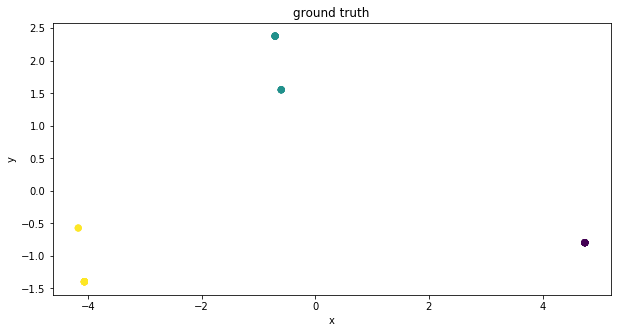

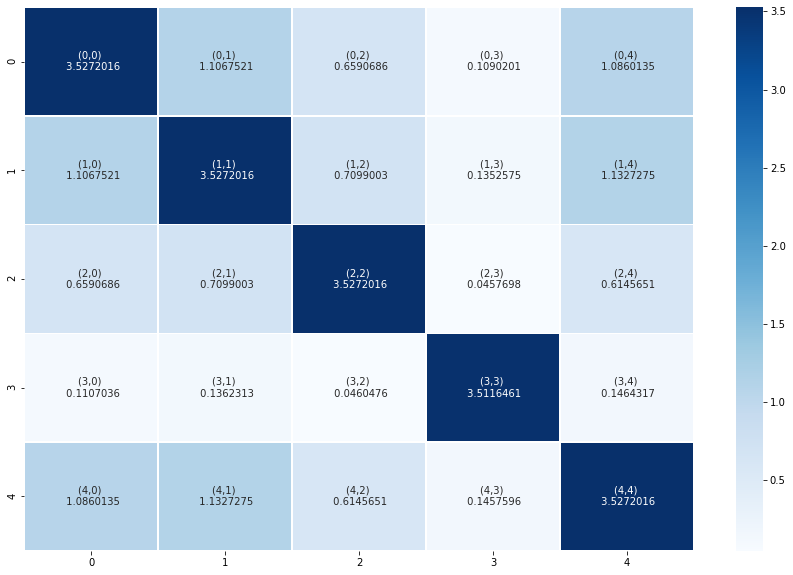

<Figure size 432x288 with 0 Axes>

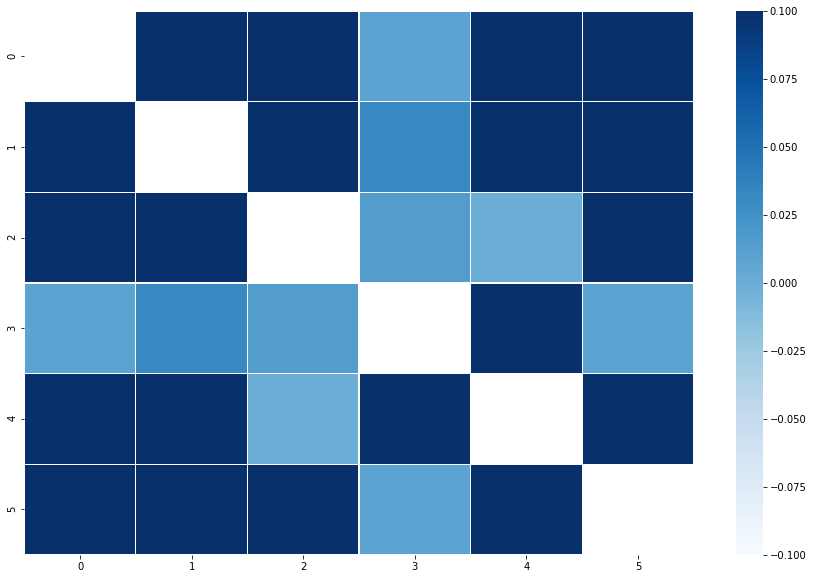

In [19]:
class_1_swap = [0, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21 , 23, 25, 27, 29] 
class_2_swap = [41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61 , 63, 65, 67, 69]
class_3_swap = [81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101 , 103, 105, 107, 109] 

X_mrmr_base_swap = swap_multiple(X_mrmr_base,3,class_1_swap,class_2_swap,class_3_swap)
# print("X_mrmr_base_swap: \n", X_mrmr_base_swap)

fig_num = 1
mrmr_dummy_df = pd.DataFrame(np.concatenate((X_mrmr_base_swap, y_mrmr_base.reshape(-1, 1)), axis=1))
dummy_df_, dummy_labels, dummy_colum_indices,mim = mrmrSelection(mrmr_dummy_df, 4)
print("Selected Features by MRMR: ", dummy_colum_indices)

visualize_clusters(X_mrmr_base_swap, y_mrmr_base, fig_num)
arr, heat_map_labels = computeMIMatrix(X_mrmr_base_swap, fig_num)

fig,ax = plt.subplots(figsize=(15,10))
title = "Mutual Information between pairwise features"
sns.heatmap(mim, fmt="",cmap="Blues", linewidth=0.3, ax=ax)
path = 'mim_extracted_' + str(fig_num) + '.png'
# plt.savefig(path)

### 4.2.2 Base Dataset + Redundant

/opt/anaconda3/lib/python3.7/site-packages/rpy2/robjects/vectors.py:927: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


Selected Features by MRMR:  [0, 2, 1, 4, 3]


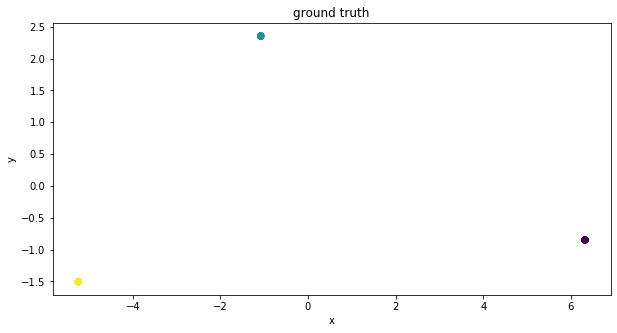

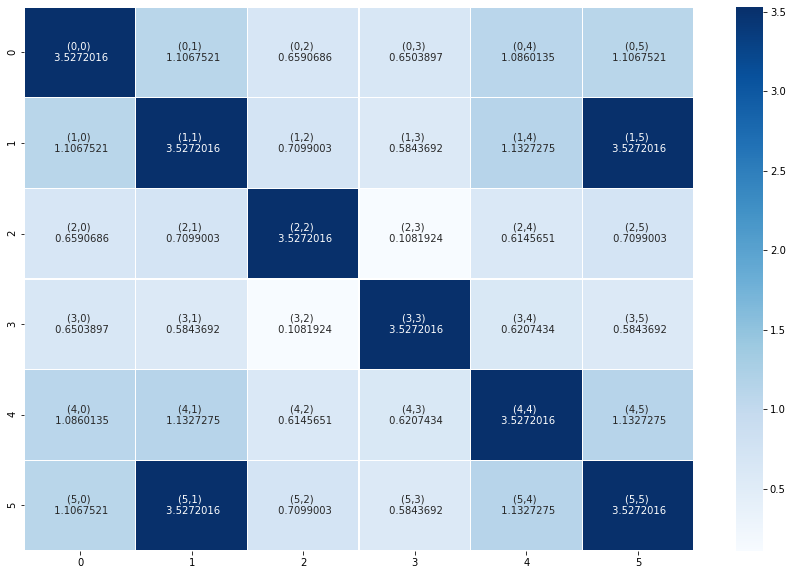

<Figure size 432x288 with 0 Axes>

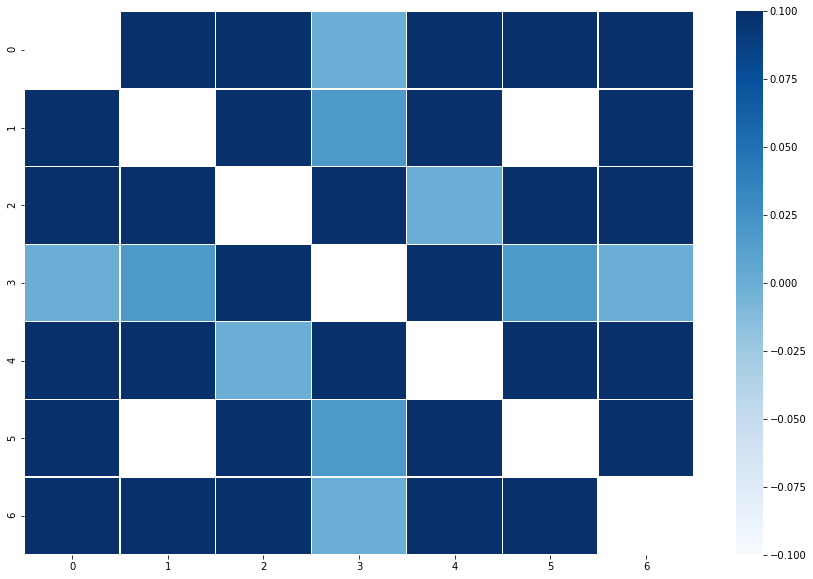

In [20]:
X_mrmr_base_redundant = np.concatenate((X_mrmr_base, np.asarray(reduandant_col_1).reshape(-1,1)), axis=1)

fig_num = 1
mrmr_dummy_df = pd.DataFrame(np.concatenate((X_mrmr_base_redundant, y_mrmr_base.reshape(-1, 1)), axis=1))
dummy_df_, dummy_labels, dummy_colum_indices,mim = mrmrSelection(mrmr_dummy_df, 5)
print("Selected Features by MRMR: ", dummy_colum_indices)

visualize_clusters(X_mrmr_base_redundant, y_mrmr_base, fig_num)
arr, heat_map_labels = computeMIMatrix(X_mrmr_base_redundant, fig_num)

fig,ax = plt.subplots(figsize=(15,10))
title = "Mutual Information between pairwise features"
sns.heatmap(mim, fmt="",cmap="Blues", linewidth=0.3, ax=ax)
path = 'mim_extracted_' + str(fig_num) + '.png'

### 4.2.3 Base Dataset + Noise

[[  1.00010652   2.00008438   3.00015007   3.99988273   5.00005111
  235.73209791]
 [  0.99989987   2.00013792   3.00018704   3.99995085   5.00004099
  210.19904583]
 [  0.99987929   2.00008607   2.9999125    4.00002144   5.00000252
  540.99527883]
 [  0.99987902   1.99993722   2.99994848   4.0000439    5.00001021
  903.88932712]
 [  0.99984214   1.99991652   3.00000059   3.99991542   5.00011455
  521.23012358]
 [  1.00007084   2.00009476   2.99993323   4.00000431   5.00015853
  737.87429334]
 [  0.99990007   2.00004678   3.00014194   4.00005897   5.00021265
  749.84940228]
 [  0.99992121   1.99994896   2.99985423   4.00009722   4.99993161
  219.06892182]
 [  0.99986987   1.99995069   2.99999669   4.00003586   4.99994387
  885.01455833]
 [  1.00000798   2.00002226   2.9997394    3.99998948   5.0001219
  261.44965046]
 [  0.99974706   1.99989672   3.00001814   4.00004066   5.00008066
  630.90258375]
 [  0.99992453   1.99979054   2.99991346   4.00006148   5.00000795
  411.18605542]
 [  0

/opt/anaconda3/lib/python3.7/site-packages/rpy2/robjects/vectors.py:927: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


Selected Features by MRMR:  [0, 2, 1, 4, 5]


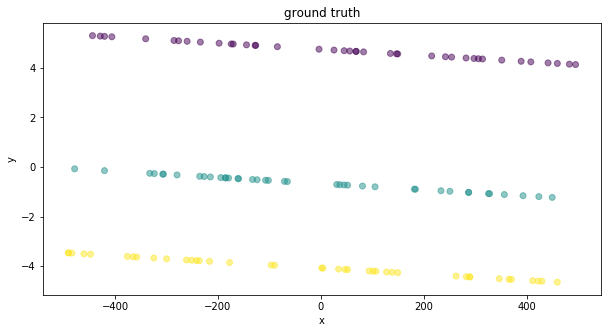

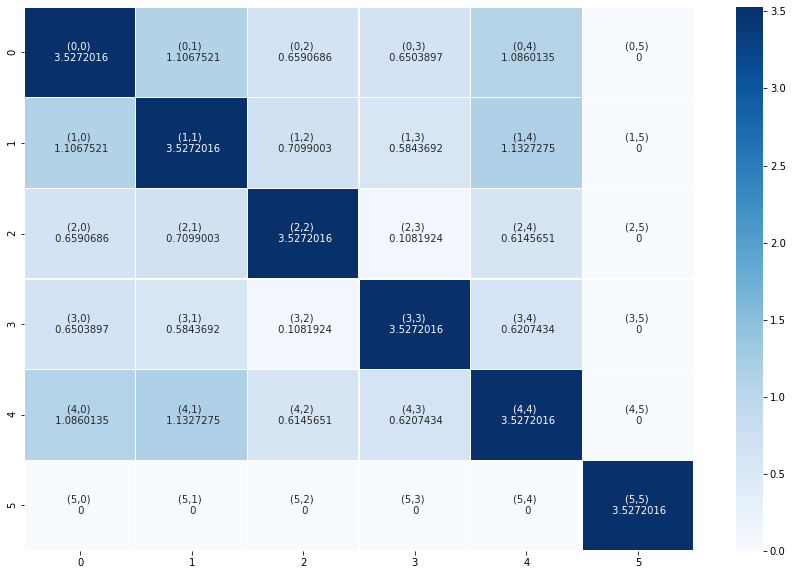

<Figure size 432x288 with 0 Axes>

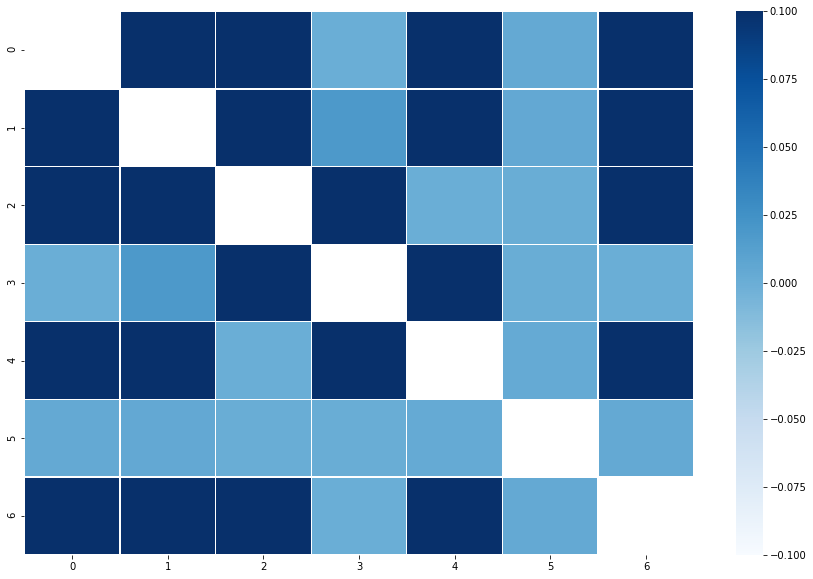

In [21]:
X_mrmr_base_noise = np.concatenate((X_mrmr_base, np.asarray(noise_col_1[:,0]).reshape(-1,1)), axis=1)
print(X_mrmr_base_noise)
fig_num = 2
mrmr_dummy_df = pd.DataFrame(np.concatenate((X_mrmr_base_noise, y_mrmr_base.reshape(-1, 1)), axis=1))
dummy_df_, dummy_labels, dummy_colum_indices,mim = mrmrSelection(mrmr_dummy_df, 5)
print("Selected Features by MRMR: ", dummy_colum_indices)

visualize_clusters(X_mrmr_base_noise, y_mrmr_base, fig_num)
arr, heat_map_labels = computeMIMatrix(X_mrmr_base_noise, fig_num)

fig,ax = plt.subplots(figsize=(15,10))
title = "Mutual Information between pairwise features"
sns.heatmap(mim, fmt="",cmap="Blues", linewidth=0.3, ax=ax)
path = 'mim_extracted_' + str(fig_num) + '.png'

### 4.2.4 Base Dataset + Redundant + Noise

/opt/anaconda3/lib/python3.7/site-packages/rpy2/robjects/vectors.py:927: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


Selected Features by MRMR:  [0, 2, 1, 4, 5]


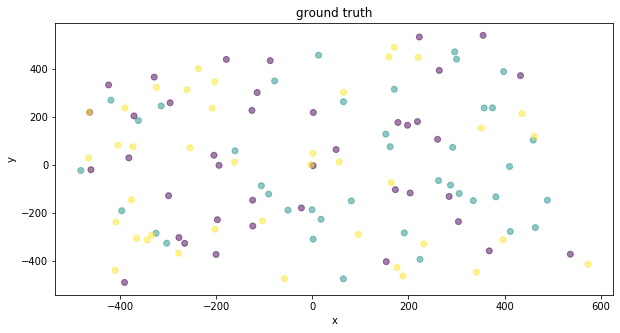

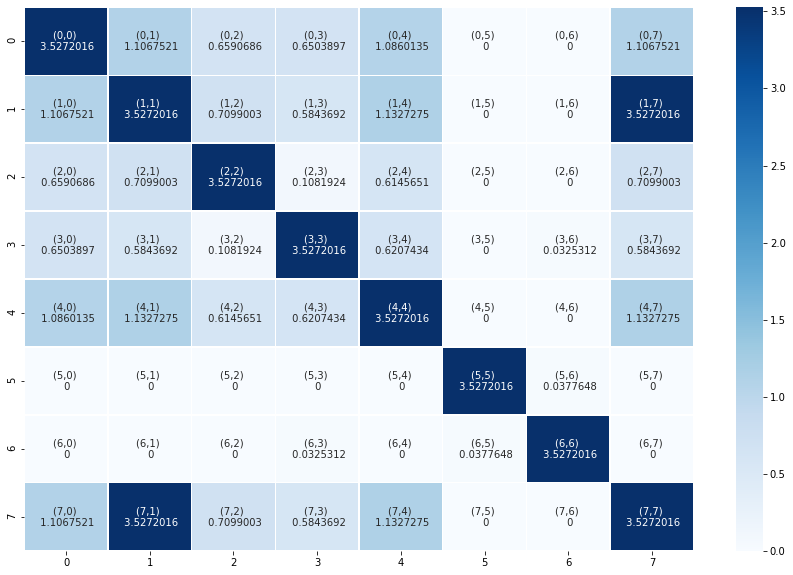

<Figure size 432x288 with 0 Axes>

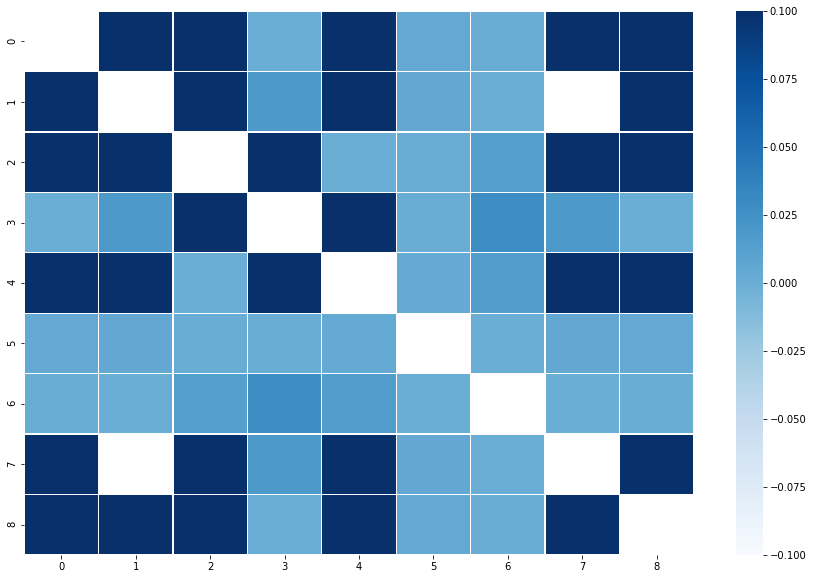

In [22]:
X_mrmr_base_noise = np.concatenate((X_mrmr_base, np.asarray(noise_col_1)), axis=1)
X_mrmr_base_noise_redundant = np.concatenate((X_mrmr_base_noise, np.asarray(reduandant_col_1).reshape(-1,1)), axis=1)
# print(X_mrmr_base_noise)
fig_num = 2
mrmr_dummy_df = pd.DataFrame(np.concatenate((X_mrmr_base_noise_redundant, y_mrmr_base.reshape(-1, 1)), axis=1))
dummy_df_, dummy_labels, dummy_colum_indices,mim = mrmrSelection(mrmr_dummy_df, 5)
print("Selected Features by MRMR: ", dummy_colum_indices)

visualize_clusters(X_mrmr_base_noise_redundant, y_mrmr_base, fig_num)
arr, heat_map_labels = computeMIMatrix(X_mrmr_base_noise_redundant, fig_num)

fig,ax = plt.subplots(figsize=(15,10))
title = "Mutual Information between pairwise features"
sns.heatmap(mim, fmt="",cmap="Blues", linewidth=0.3, ax=ax)
path = 'mim_extracted_' + str(fig_num) + '.png'

# 5. Classification Step
## 5.1 Classification Step Validation
### 5.1.1 Classify Dataset with Noise and Redundancy Added Before MRMR Step

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [30]:
n_total = 10
n_informative = 5
n_redundant = 5

X_before_mrmr, y_before_mrmr = make_classification(shuffle=False, n_samples=1000,n_features=n_total,n_redundant=n_redundant,n_classes=4,n_informative=n_informative,n_clusters_per_class=2,class_sep=1)

X_train, X_test, y_train, y_test = train_test_split(X_before_mrmr, y_before_mrmr, test_size=0.2, random_state=42)

clf_svc = SVC()
clf_svc.fit(X_train, y_train)
pred_y_svc = clf_svc.predict(X_test)
acc_score = accuracy_score(y_test, pred_y_svc)
print("SVM Classifier Accuracy Score: ", acc_score)

clf_rf = RandomForestClassifier(random_state=0)
clf_rf.fit(X_train, y_train)
pred_y_rf = clf_rf.predict(X_test)
acc_score = accuracy_score(y_test, pred_y_rf)
print("RF Classifier Accuracy Score: ", acc_score)

clf_lr = LogisticRegression(random_state=0)
clf_lr.fit(X_train, y_train)
pred_y_lr = clf_lr.predict(X_test)
acc_score = accuracy_score(y_test, pred_y_lr)
print("LR Classifier Accuracy Score: ", acc_score)

SVM Classifier Accuracy Score:  0.77
RF Classifier Accuracy Score:  0.81
LR Classifier Accuracy Score:  0.595


# 6. Integrated Validation
## 6.1 Import all pipeline steps

In [222]:
def t_test(X, y):
    
    def separate(X, y):
        # Y is the classes (1=stable, 2=progressor)
        P_X, S_X = [], []
        for i in range(X.shape[0]):
            if  y[i] == 0:
                S_X.append(X[i])
            elif y[i] == 1:
                P_X.append(X[i])
        return np.asarray(P_X), np.asarray(S_X)

    def t_test(P, S, y):
        t_vals = []
        for i in range(P.shape[1]):
            t_score, p_val = stats.ttest_ind(P[:,i], S[:,i])
            tuple_ = (abs(t_score), abs(p_val))
            t_vals.append((tuple_, i))
        return t_vals

    def select(X, y, t_vals, percentage=.75):
        total_nfeatures = X.shape[1]
        filtered_nfeatures = math.ceil(total_nfeatures*percentage)
#         print("total_nfeatures: ",total_nfeatures)
#         print("filtered_nfeatures", filtered_nfeatures)
        sorted_t_val = sorted(t_vals, key=lambda tup: tup[0][0], reverse=True)
#         print(sorted_t_val)
        selected_indices = [i[1] for i in sorted_t_val[:filtered_nfeatures]]
        sorted_selected_indices = sorted(selected_indices)
        X_reduced = X[:,sorted_selected_indices]
        return X_reduced, sorted_selected_indices
    
    P_X, S_X = separate(X, y)
    t_vals = t_test(P_X, S_X, y)
    X_reduced, selected_indices = select(X, y, t_vals)
    return X_reduced, selected_indices

from snf import compute

class Clustering():

    def __init__(self, debug_mode=False):
        """Apply fit_transform on the training data

            Arguments
            ---------
                debug_mode: boolean
                    If true, intermediate results will be printed for debugging purposes 
                    at the end of each function call.
        """
        self.debug_mode = debug_mode
        pass

    # setter for number of subclusters for P
    def setNumP(self, numP):
        self.numP = numP

    # setter for number of subclusters for S
    def setNumS(self, numS):
        self.numS = numS

    # Step1. Separate out P and S
    def separate(self, X, y):
        """Separate out the progressor and stable instances to be used for clustering later. 

            As the data in is reindexed by the stratifiedKfold. It is important for us
            to save the indexes of the rows before we separate them out and do clustering 
            accordingly. In this function, while the data is splitted into separate lists 
            by class, the original index for each row is saved. After the clustering is done, 
            we will reindex our combined data set according to the saved indexes.

            Arguments
            ---------
                X: numpy.ndarray
                    The combined data
                y: numpy.ndarray
                    The combined data labels.
            Returns
            -------
                P_X: list
                    Progressor data
                P_y: list
                    Progressor data labels
                S_X: list
                    Stable data
                S_y: list
                    Stable data labels     
        """

        # initialize empty lists to store index of P&S instances in the
        # original data
        index_P, index_S = [], []

        # initialize lists to store the separated P and S instances
        P_X, P_y, S_X, S_y = [], [], [], []
        # store P and S instances separately and keep track of the indexes in
        # the original data

        for i in range(0, y.shape[0]):
            if y[i] == 1:
                S_X.append(X[i])
                S_y.append(y[i])
                index_S.append(i)
            else:
                P_X.append(X[i])
                P_y.append(y[i])
                index_P.append(i)

        # store the indexes as a global attribute for the clasds
        self.index_P = index_P
        self.index_S = index_S

        # print all the computed matrxi if debug mode is enabled
        if self.debug_mode == True:
            print("index_P", self.index_P)
            print("index_S", self.index_S)

#         print("P_X separate", P_X)
        return np.asarray(P_X), np.asarray(P_y), np.asarray(S_X), np.asarray(S_y)

    def clusteringP(self, P_X):
        """Apply Spectral Clustering on Progressor data.

            SpectralClustering is performed on P class instances. The number of clusters 
            is specified by the global attribute num_P. At the end of the step, the original
            labels will be discarded and the new labels will be attached to the end of the data
            for convenience. The assign_labels for the SpectralClustering is "discrete" and 
            random_state is set to 0. 

            Arguments
            ---------
                P_X: list
                    The progressor data.
            Returns
            -------
                P_X_clustered: numpy.ndarray
                    The combined clustered progressor data with new labels attached to the end.
        """
        affinity_networks = compute.make_affinity(P_X, metric='euclidean', K=self.numP, mu=0.5)
        
        clusteringP = SpectralClustering(affinity='precomputed',
            n_clusters=self.numP, random_state=0).fit(affinity_networks)
        
        labels = clusteringP.labels_.reshape(-1, 1)
        P_X = np.asarray(P_X)
        P_X_clustered = np.concatenate((P_X, labels), axis=1)

        if self.debug_mode == True:
            print("P labels", np.reshape(labels, (1, -1)))
            print("P_X_clustered", P_X_clustered)

        return P_X_clustered

    def clusteringS(self, S_X):
        """Apply Spectral Clustering on Stable data.

            SpectralClustering is performed on the S class instances. The number of clusters 
            is specified by the global attribute num_S. At the end of the step, the original
            labels will be discarded and the new labels will be attached to the end of the data
            for convenience. The assign_labels for the SpectralClustering is "discrete" and 
            random_state is set to 0. 

            Arguments
            ---------
                S_X: list
                    The progressor data.
            Returns
            -------
                S_X_clustered: numpy.ndarray
                    The combined clustered progressor data with new labels attached to the end.
        """

        affinity_networks = compute.make_affinity(S_X, metric='euclidean', K=self.numS, mu=0.5)
        
        clusteringS = SpectralClustering(affinity='precomputed',
            n_clusters=self.numS, random_state=0).fit(affinity_networks)

        labels = clusteringS.labels_
        labels = labels + self.numP
        S_X = np.asarray(S_X)
        labels = labels.reshape(-1, 1)
        S_X_clustered = np.concatenate((S_X, labels), axis=1)

        if self.debug_mode == True:
            print("S labels", np.reshape(labels, (1, -1)))
            print("S_X_clustered", S_X_clustered)

        return S_X_clustered

    def transform(self, X, y):
        """Apply Spectral Clustering on stable data and progressor data. 
            Step 1. Separate data out into P and S classes. Save the original data index as 
            the data rows will be reindexed for clustering. 
            Step 2. Perform clustering for P class based on num_P. Attach the new labels.
            Step 3. Perform clustering for S class based on num_S. Attach the new labels. 
            Step 4. Combine the newly clustered P class data and S class data. Reindex the 
            data rows according to the saved indexes. 
            Arguments
            ---------
                X: numpy.ndarray
                    The combined data of both P and S instances.
                y: numpy.ndarray
                    The combined data labels.
            Returns
            -------
                X_output: numpy.ndarray
                    The combined data with newly clustered labels attached.
        """

        P_X, P_y, S_X, S_y = self.separate(X, y)

        P_X_clustered = self.clusteringP(P_X)
        S_X_clustered = self.clusteringS(S_X)

        P_X_clustered_with_index = np.concatenate(
            (P_X_clustered, (np.array(self.index_P)).reshape(-1, 1)), axis=1)
        S_X_clustered_with_index = np.concatenate(
            (S_X_clustered, (np.array(self.index_S)).reshape(-1, 1)), axis=1)

        X_combined_with_index = np.concatenate(
            (P_X_clustered_with_index, S_X_clustered_with_index), axis=0)

        X_sorted = X_combined_with_index[
            np.argsort(X_combined_with_index[:, -1])]
        new_labels = X_sorted[:,-2]
        X_output = X_sorted[:, :-2]

        if self.debug_mode == True:
            print("P_X_clustered_with_index", P_X_clustered_with_index)
            print("S_X_clustered_with_index", S_X_clustered_with_index)
            print("X_sorted", X_sorted)
            print("X_output", X_output)
            print("X_output.labels", X_output[:, -1])

        return X_output, new_labels
    
    
def mrmrSelection(dataframe, nFeature):
    """Perform MRMR on the passed in data. 

        This function performs feature selection based on the mRMRe feature selection. 
        It utilizes the mRMRe package originally written in R. A python wrapper for R is
        used here. The eMRMRe returns a list of the selected column indices given the 
        number of features to be selected. 

        Arguments
        ---------
            dataframe: pandas.DataFrame
                The dataframe containing clustered data. 
        Returns
        -------
            df_: pandas.DataFrame
                The dataframe with only selected columns.
            labels: pandas.DataFrame
                The dataframe of only the labels
            colum_indices: list
                The list of indices of the selected columns
    """ 
    base = importr('base')
    mr = importr('mRMRe')
    pandas2ri.activate()
    # Convert the data into R format
    with localconverter(ro.default_converter + pandas2ri.converter):
        rdataframe = ro.conversion.py2rpy(dataframe)
    mrmrData = mr.mRMR_data(data = (rdataframe))
    solutionCount = 1
    selectionEnsemble = mr.mRMR_ensemble("mRMRe.Data",data = mrmrData, target_indices = (dataframe.shape[1]),
          feature_count = nFeature, solution_count = solutionCount)
    colum_indices =(mr.solutions(selectionEnsemble)[0]-1)
    mutual_information_matrix = mr.mim(mrmrData)
    df_ = pd.DataFrame()
    for i,v in enumerate(colum_indices):
        df_[i] = dataframe[v[0]]
    labels = dataframe.iloc[:,-1]
    colum_indices = list(np.reshape(colum_indices,(1,-1))[0])
    return df_, labels, colum_indices, mutual_information_matrix


### 6.2 Generate a set of simulated data
- n_samples=302
- n_features=75 
- n_informative=50 
- n_redundant=0 
- n_classes=2 
- n_clusters_per_class=3 
- weights=None 
- class_sep=15.0 
- hypercube=True
- shuffle=False
- random_state=None

In [240]:
X,y = make_classification(n_samples=302, 
                          n_features=75, 
                          n_informative=50, 
                          n_redundant=0, 
                          n_classes=2, 
                          n_clusters_per_class=3, 
                          weights=None, 
                          class_sep=15.0, 
                          hypercube=True,
                          shuffle=False, 
                          random_state=None)

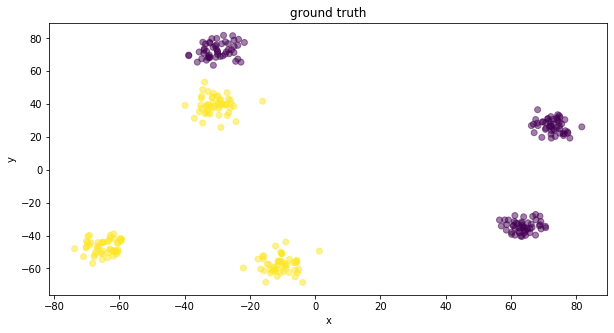

In [241]:
visualize_clusters(X, y, 1)

### 6.3 Save the generated dataset to disk

In [246]:
import pickle
filename_x = 'X.p'
filename_y = 'y.p'
with open(filename_x, 'wb') as filehandler:
    pickle.dump(X, filehandler)
with open(filename_y, 'wb') as filehandler:
    pickle.dump(y, filehandler)

In [331]:
with open(filename_y, 'rb') as filehandler: 
    y_integrated = pickle.load(filehandler)
    print(y_integrated)
    
with open(filename_x, 'rb') as filehandler: 
    X_integrated = pickle.load(filehandler)
    print(X_integrated)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[[ 11.75678611  16.77479867 -13.7755842  ...   2.63765447   0.384971
    1.08506695]
 [ 10.37831134  14.01906336 -13.05671759 ...  -1.23708167  -0.64197089
   -1.43364081]
 [ 15.93013636  17.91844872 -18.12787246 ...   1.29464305   1.78034958
    0.31120284]
 ...
 [-19.73870217  14.60206615 -19.64602613 ...  -1.59177923  -1.32954633
   -0.4543141 ]
 [-14.81401695  11.14628153  -9.676

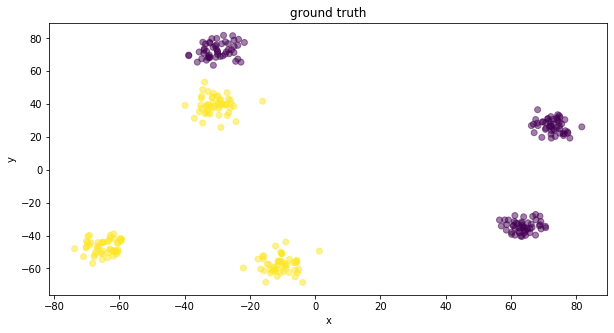

In [332]:
visualize_clusters(X_integrated, y_integrated, 1)

In [333]:
p_index = [index for index,i in enumerate(y) if i==0]
s_index = [index for index,i in enumerate(y) if i==1]
print(p_index)
print(s_index)
print(y_integrated[p_index])
print(y_integrated[s_index])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251]
[51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171

In [334]:
Xp = X_integrated[p_index]
Xs = X_integrated[s_index]
yp = y_integrated[p_index]
ys = y_integrated[s_index]

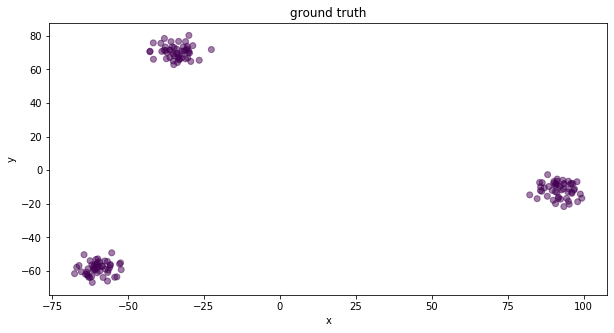

In [335]:
visualize_clusters(Xp, yp, 1)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


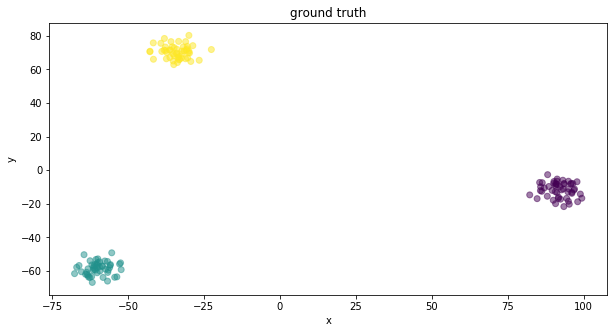

In [336]:
kmeans_p = KMeans(n_clusters=3, random_state=0).fit(Xp)
print(kmeans_p.labels_)
visualize_clusters(Xp, kmeans_p.labels_, 1)
p_sublabel = kmeans_p.labels_

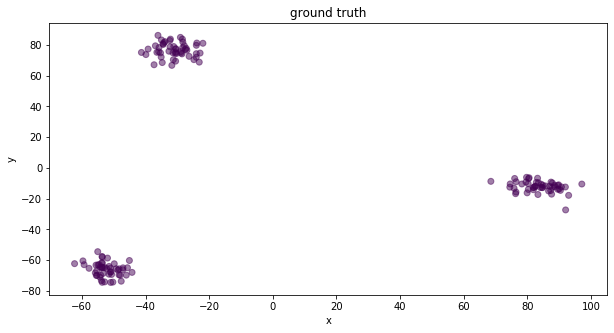

In [337]:
visualize_clusters(Xs, ys, 1)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4]


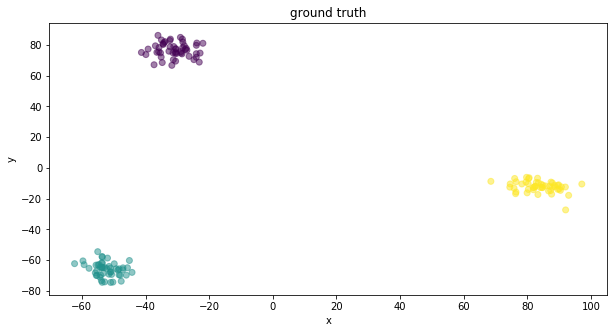

In [338]:
kmeans_s = KMeans(n_clusters=3, random_state=0).fit(Xs)
print(kmeans_s.labels_)
visualize_clusters(Xs, kmeans_s.labels_, 1)
s_sublabel = kmeans_s.labels_ + 3
print(s_sublabel)

In [339]:
X_concat = np.concatenate((Xp, Xs),axis=0)
y_concat = np.concatenate((yp, ys),axis=0)
sublabel_concat = np.concatenate((p_sublabel,s_sublabel),axis=0)
# print(y_concat)
# print(sublabel_concat)
informative=X_concat[:,0:25]
redundant=informative.copy()
for i in range(25):
    redundant[:,i] = redundant[:,i]*2
# print(informative)
# print(redundant)
# print(X_concat.shape)
X_new = np.zeros((302,100))
X_new[:,0:50] = X_concat[:,0:50]
X_new[:,50:75] = redundant
X_new[:,75:100] = X_concat[:,50:75]

In [340]:
X_after_ttest, columns_ttest = t_test(X_new, y_concat)
print(columns_ttest)
print(len(columns_ttest))

num_informative=0
num_redundant=0
num_uninformative=0

for i in columns_ttest:
    if i<50:
        num_informative=num_informative+1
    if 50<=i<75:
        num_redundant=num_redundant+1
    if i>= 75:
        num_uninformative = num_uninformative+1
print(count/75)

print("number of informative: ", num_informative)
print("number of redundant: ", num_redundant)
print("number of uninformative: ", num_uninformative)

[1, 2, 3, 4, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 38, 39, 40, 41, 43, 44, 46, 48, 49, 51, 52, 53, 54, 57, 58, 59, 61, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 95, 96, 99]
75
0.6666666666666666
number of informative:  39
number of redundant:  19
number of uninformative:  17


In [341]:
integrated_clustering = Clustering()
integrated_clustering.setNumP(3)
integrated_clustering.setNumS(3)
X_train_clustered, y_train_new = integrated_clustering.transform(
    X_after_ttest, y_concat)

print(y_train_new)
print(sublabel_concat)

from collections import Counter
print(Counter(y_train_new).keys()) # equals to list(set(words))
print(Counter(y_train_new).values()) # counts the elements' frequency


from collections import Counter
print(Counter(sublabel_concat).keys()) # equals to list(set(words))
print(Counter(sublabel_concat).values()) # counts the elements' frequency

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 

In [342]:
X_train_clustered_combined = np.concatenate(
    (X_train_clustered, y_train_new.reshape(-1,1)), 
    axis=1)

print(X_train_clustered_combined.shape)

X_train_selected, y_train_selected, column_indices, mim = mrmrSelection(
    pd.DataFrame(X_train_clustered_combined), 50)

print(column_indices)
count = 0
for i in column_indices:
    if i<=75:
        count=count+1
print(count/len(column_indices))      

(302, 76)


/opt/anaconda3/lib/python3.7/site-packages/rpy2/robjects/vectors.py:927: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


[19, 18, 28, 22, 26, 2, 33, 20, 21, 25, 72, 0, 54, 6, 46, 66, 59, 4, 69, 34, 70, 38, 32, 71, 74, 36, 63, 29, 1, 67, 60, 58, 61, 73, 31, 68, 65, 47, 64, 50, 62, 51, 49, 24, 23, 48, 44, 37, 55, 52]
1.0


In [343]:
for i in range(25):
    if i in column_indices:
        if i+50 in column_indices:
            print("Redundant feature pairs found: ", i, i+50)

Redundant feature pairs found:  0 50
Redundant feature pairs found:  1 51
Redundant feature pairs found:  2 52
Redundant feature pairs found:  4 54
Redundant feature pairs found:  18 68
Redundant feature pairs found:  19 69
Redundant feature pairs found:  20 70
Redundant feature pairs found:  21 71
Redundant feature pairs found:  22 72
Redundant feature pairs found:  23 73
Redundant feature pairs found:  24 74


In [344]:
from statistics import mean

svc_acc = []
lr_acc = []
rf_acc = []   

skf_split = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
for train_inner, test_inner in skf_split.split(X_train_selected, y_train_selected): 
    X_train = X_train_selected.iloc[train_inner]
    y_train = y_train_selected.iloc[train_inner]
    X_test = X_train_selected.iloc[test_inner]
    y_test = y_train_selected.iloc[test_inner]
    
    for classifier in range(3):
        if classifier == 0:
            clf = SVC()
            clf.fit(X_train, y_train)
            pred_y = clf.predict(X_test)
            acc_score = accuracy_score(y_test, pred_y)
            svc_acc.append(acc_score)
            
        if classifier == 1:
            clf = RandomForestClassifier(random_state=0)
            clf.fit(X_train, y_train)
            pred_y = clf.predict(X_test)
            acc_score = accuracy_score(y_test, pred_y)
            rf_acc.append(acc_score)    
            
        if classifier == 2:
            clf = LogisticRegression(random_state=0, max_iter=5000)
            clf.fit(X_train, y_train)
            pred_y = clf.predict(X_test)
            acc_score = accuracy_score(y_test, pred_y)
            lr_acc.append(acc_score)            

print("svc acc: ", mean(svc_acc))
print("lr acc: ", mean(lr_acc))
print("rf acc: ", mean(rf_acc))

svc acc:  1.0
lr acc:  1.0
rf acc:  1.0
